#  STEP 1: Load & Combine Datasets 

Train shape: (1460, 81)
Test shape: (1459, 80)
Combined shape: (2919, 80)

 Features with missing values:

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
MasVnrType      60.500171
FireplaceQu     48.646797
LotFrontage     16.649538
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
GarageYrBlt      5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Functional       0.068517
Utilities        0.068517
GarageArea       0.034258
GarageCars       0.034258
Electrical       0.034258
KitchenQual      0.034258
TotalBsmtSF      0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: fl

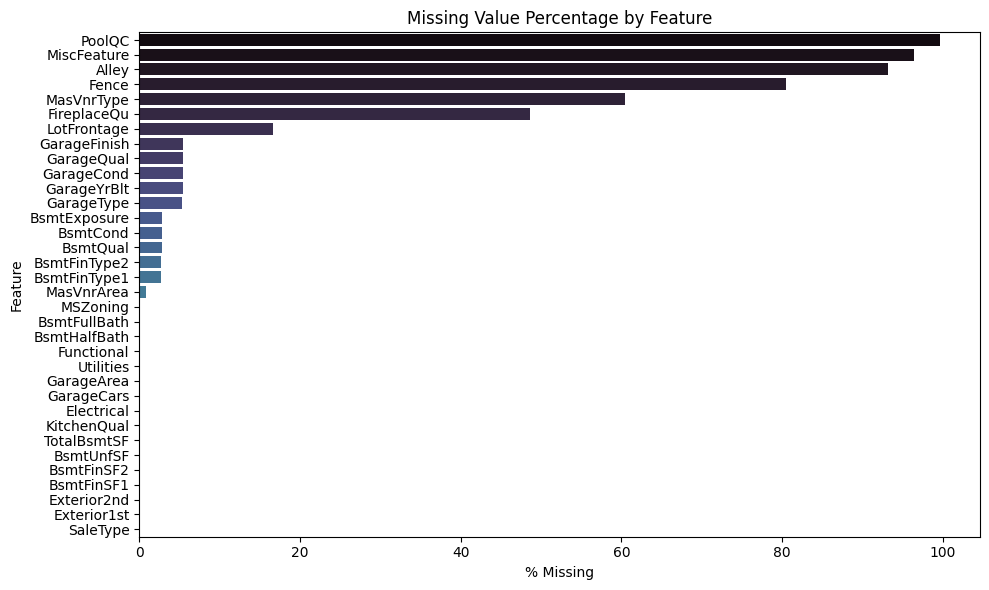

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")


train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train.columns = train.columns.str.strip() 

test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


train_labels = train["SalePrice"]
train.drop("SalePrice", axis=1, inplace=True)


test_ids = test["Id"]


combined = pd.concat([train, test], axis=0)
print(f"Combined shape: {combined.shape}")


null_percent = combined.isnull().mean() * 100
null_df = null_percent[null_percent > 0].sort_values(ascending=False)
print("\n Features with missing values:\n")
print(null_df)


plt.figure(figsize=(10,6))
sns.barplot(x=null_df.values, y=null_df.index, palette="mako")
plt.title("Missing Value Percentage by Feature")
plt.xlabel("% Missing")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


#  Step 2: EDA — Understand the Data Deeply


*  2.1. Distribution of Target Variable SalePrice

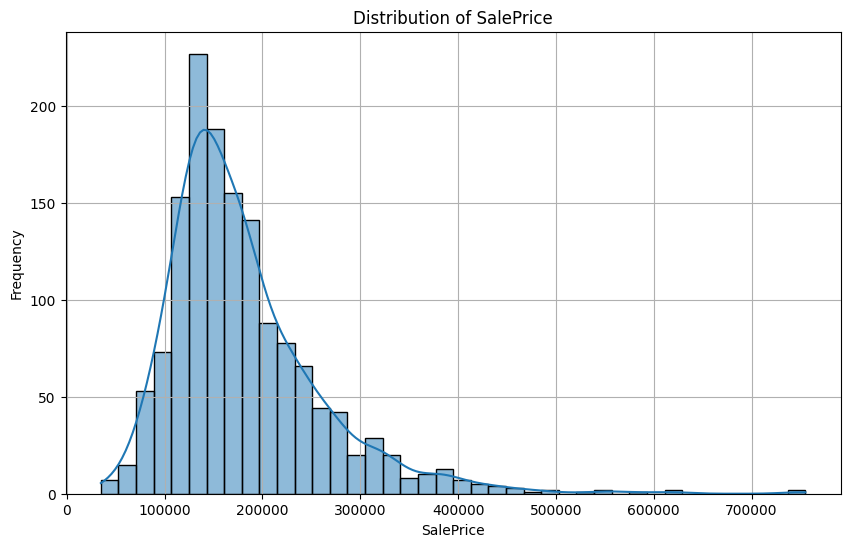

Skewness of SalePrice: 1.88


In [13]:
plt.figure(figsize=(10,6))
sns.histplot(train_labels, kde=True, bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Check skewness
skewness = train_labels.skew()
print(f"Skewness of SalePrice: {skewness:.2f}")


*  2.2. Log Transform Target Variable (for RMSLE & better modeling)

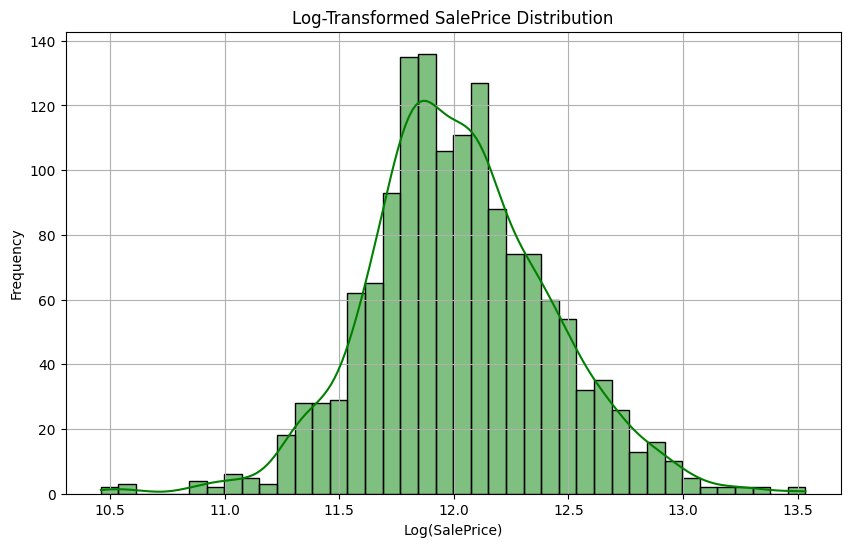

Skewness after log transform: 0.12


In [14]:
train_labels_log = np.log1p(train_labels)  # Use train_labels, not train['SalePrice']


plt.figure(figsize=(10,6))
sns.histplot(train_labels_log, kde=True, bins=40, color='green')
plt.title("Log-Transformed SalePrice Distribution")
plt.xlabel("Log(SalePrice)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Check skewness
print(f"Skewness after log transform: {train_labels_log.skew():.2f}")


*  2.3. Correlation Matrix (Top features correlated with SalePrice)

🔍 Top features correlated with SalePrice:

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


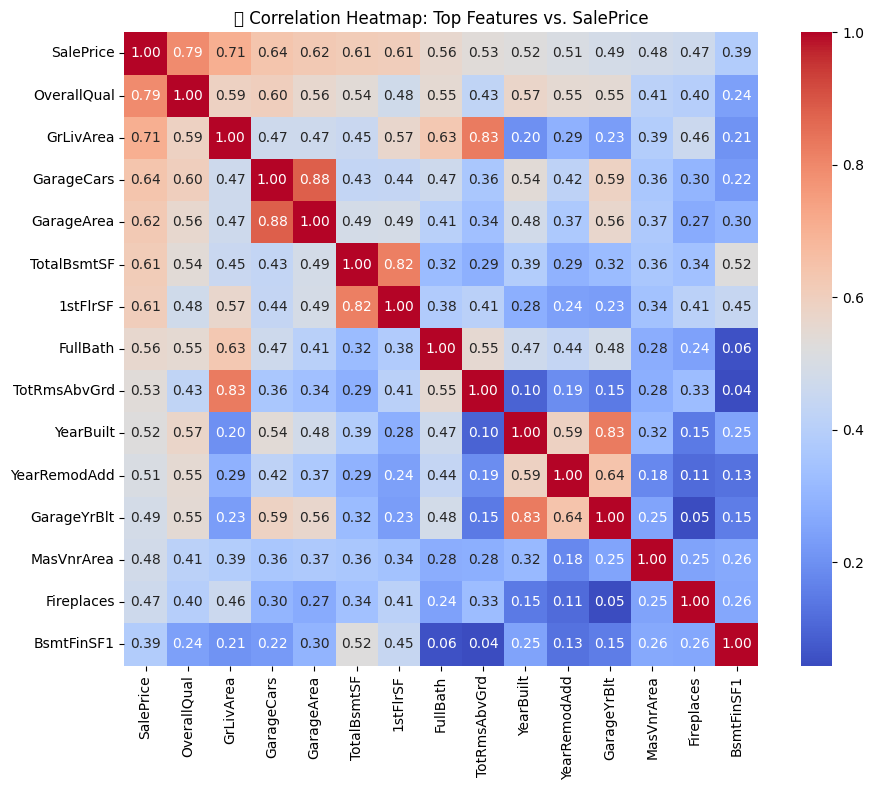

In [15]:
# Restore SalePrice back to `train` before doing correlation analysis
train['SalePrice'] = train_labels  # From Step 3 where we originally dropped it

# Compute correlation matrix for numerical features only
correlation_matrix = train.corr(numeric_only=True)

# Get top 15 features most correlated with SalePrice
top_corr = correlation_matrix['SalePrice'].sort_values(ascending=False).head(15)

print("🔍 Top features correlated with SalePrice:\n")
print(top_corr)

# Heatmap of top correlated features
plt.figure(figsize=(10, 8))
sns.heatmap(train[top_corr.index].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("🔧 Correlation Heatmap: Top Features vs. SalePrice")
plt.tight_layout()
plt.show()


*  2.4. Relationship Plots (Check linearity vs target)

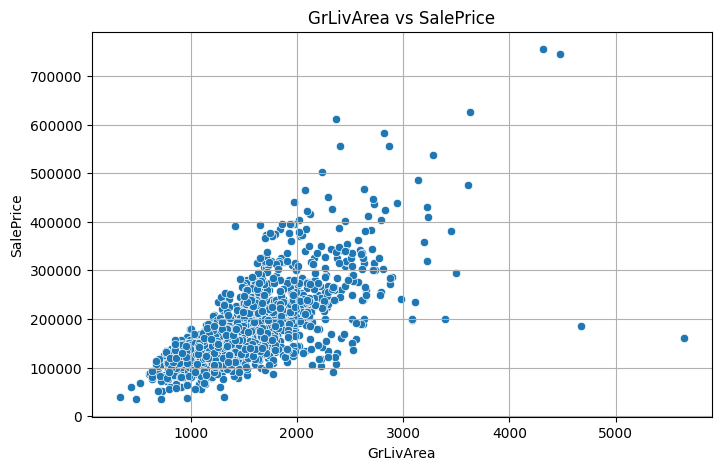

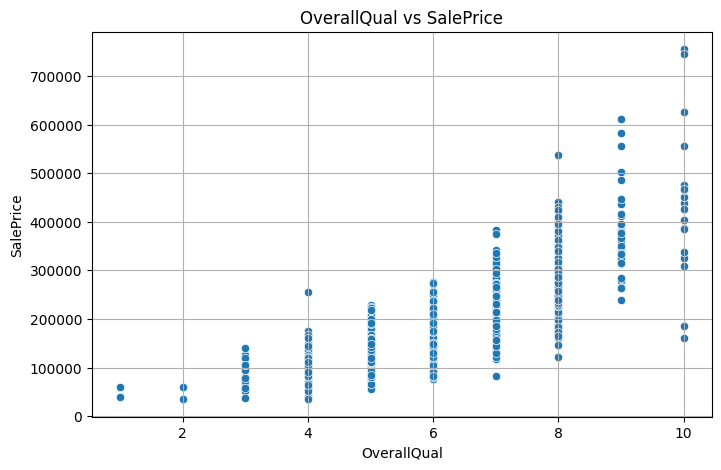

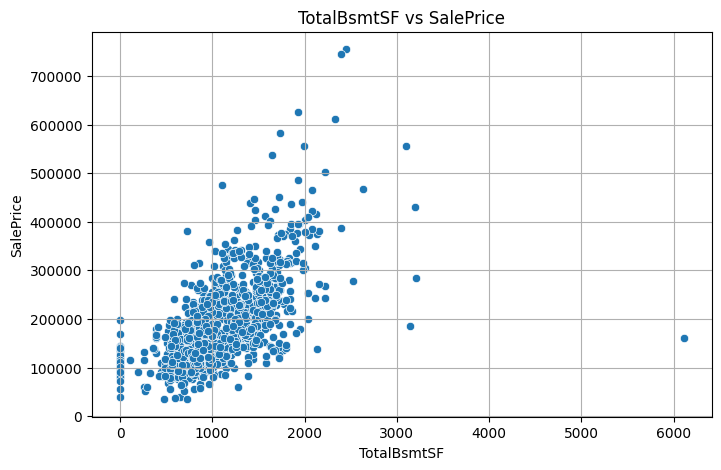

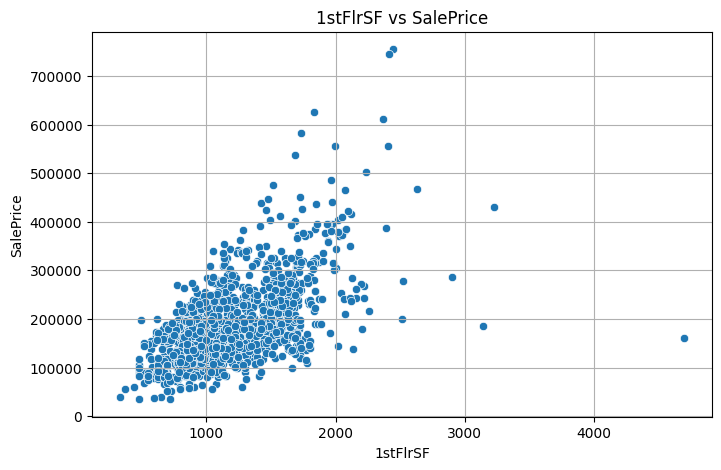

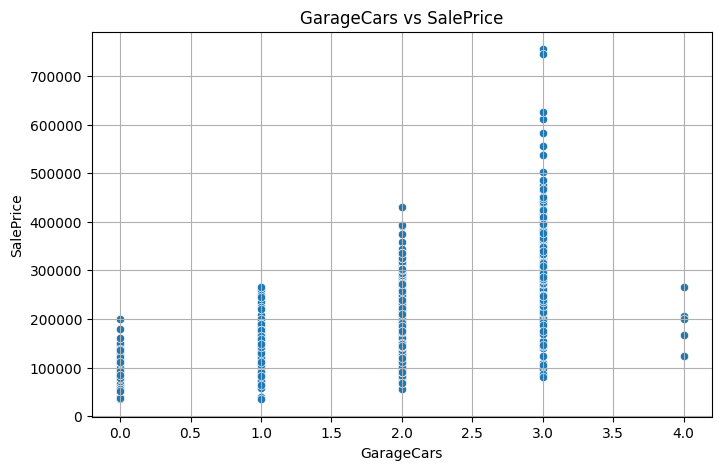

In [16]:
top_feats = ['GrLivArea', 'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GarageCars']

for col in top_feats:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=train, x=col, y='SalePrice')
    plt.title(f"{col} vs SalePrice")
    plt.grid(True)
    plt.show()


*  2.5. Boxplots for Important Categorical Variables

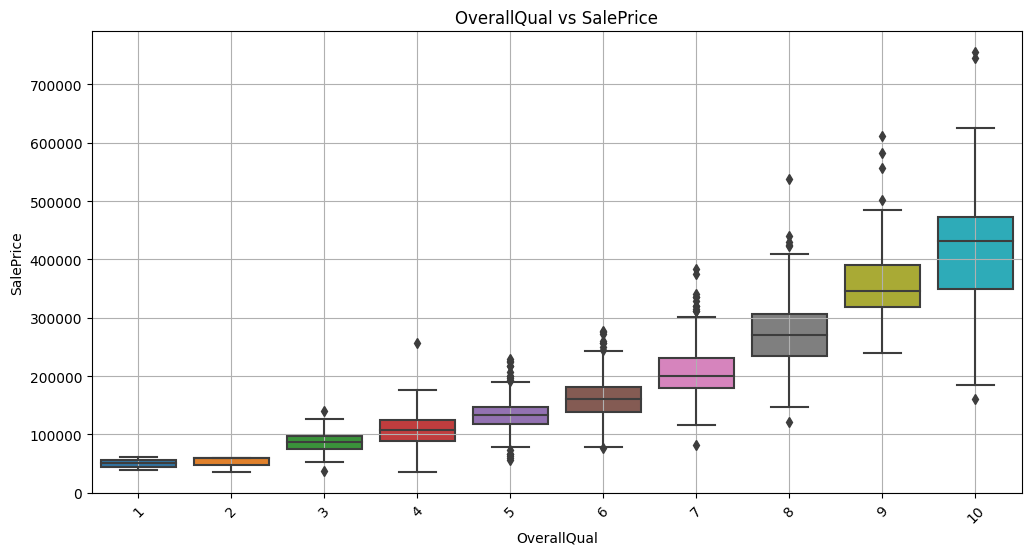

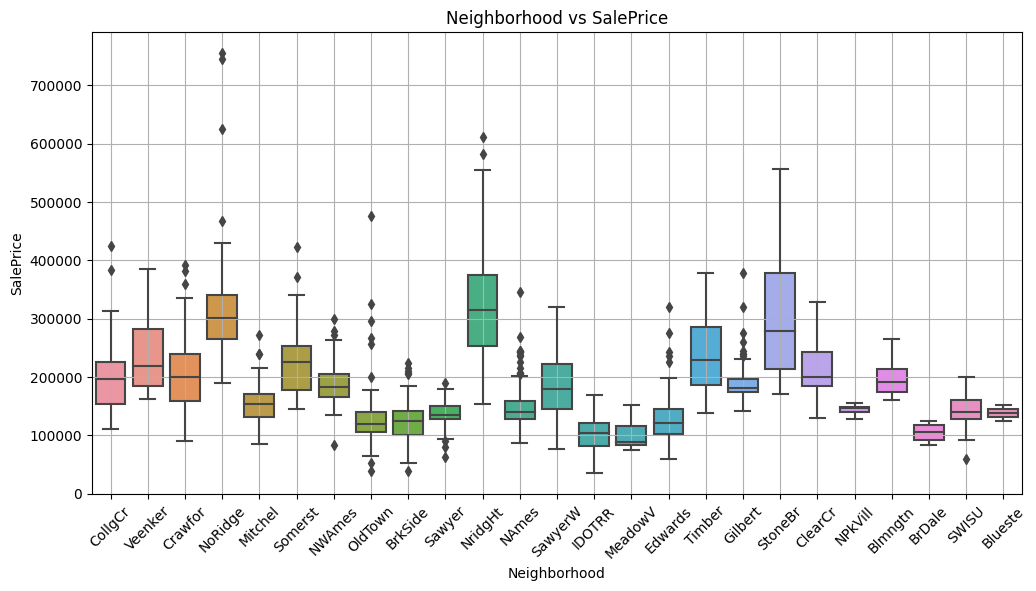

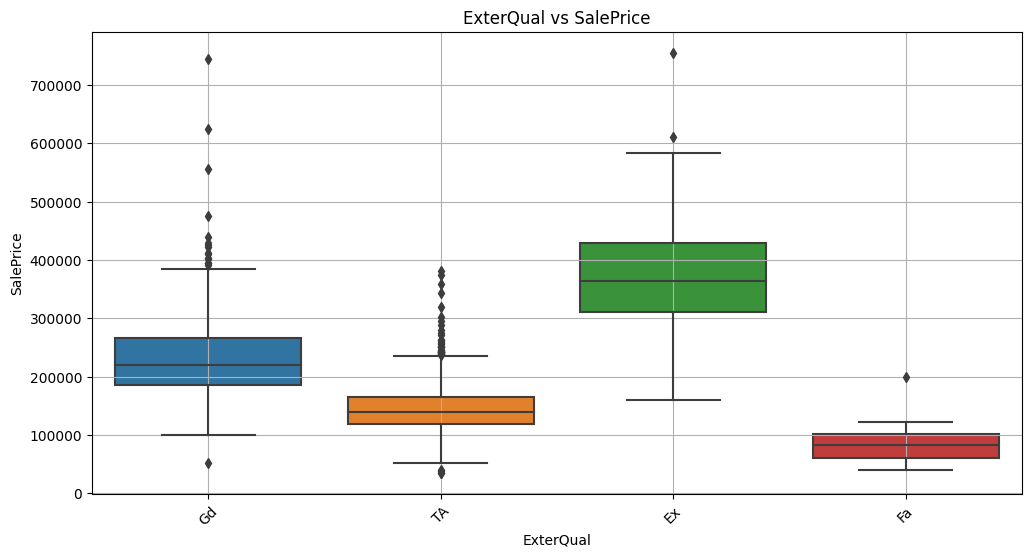

In [17]:
cat_feats = ['OverallQual', 'Neighborhood', 'ExterQual']

for cat in cat_feats:
    plt.figure(figsize=(12,6))
    sns.boxplot(x=cat, y='SalePrice', data=train)
    plt.title(f"{cat} vs SalePrice")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


#  Step 3: Missing Value Handling (Numerical → Median, Categorical → Mode)


*  3.1. Separate Numerical and Categorical Columns

In [18]:
# Split numeric and categorical columns
num_cols = combined.select_dtypes(include=['int64', 'float64']).columns
cat_cols = combined.select_dtypes(include=['object']).columns


*  3.2. Fill Missing Values: Median for Numeric, Mode for Categorical

In [19]:
# Median Imputation for Numerical
for col in num_cols:
    if combined[col].isnull().sum() > 0:
        median_val = combined[col].median()
        combined[col].fillna(median_val, inplace=True)

# Mode Imputation for Categorical
for col in cat_cols:
    if combined[col].isnull().sum() > 0:
        mode_val = combined[col].mode()[0]
        combined[col].fillna(mode_val, inplace=True)


*  3.3. Confirm All Nulls are Handled

In [20]:
missing_after = combined.isnull().sum().sum()
print(f" Total Missing Values After Imputation: {missing_after}")


 Total Missing Values After Imputation: 0


#  Step 4: Feature Engineering

*  4.1. Log-Transform Skewed Features (Excl. Target)

In [21]:
from scipy.stats import skew

# Get skewed numeric features
numeric_feats = combined.select_dtypes(include=['int64', 'float64']).columns
skewed_feats = combined[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = skewed_feats[skewed_feats > 0.75].index

print(f" Log transforming {len(skewed_cols)} skewed features...")

combined[skewed_cols] = np.log1p(combined[skewed_cols])


 Log transforming 22 skewed features...


*  4.2. Create New Features (Expert feature engineering)

In [22]:
# Total square footage
combined["TotalSF"] = combined["TotalBsmtSF"] + combined["1stFlrSF"] + combined["2ndFlrSF"]

# Age-related features
combined["HouseAge"] = combined["YrSold"] - combined["YearBuilt"]
combined["RemodAge"] = combined["YrSold"] - combined["YearRemodAdd"]
combined["GarageAge"] = combined["YrSold"] - combined["GarageYrBlt"]

# Simplify some categorical features
combined["SimplOverallQual"] = combined["OverallQual"].apply(lambda x: 1 if x <= 4 else (2 if x <= 6 else (3 if x <= 8 else 4)))
combined["SimplOverallCond"] = combined["OverallCond"].apply(lambda x: 1 if x <= 4 else (2 if x <= 6 else (3 if x <= 8 else 4)))


In [23]:
# Apply log1p to engineered numeric features
engineered_numeric_cols = ["TotalSF", "HouseAge", "RemodAge", "GarageAge"]
combined[engineered_numeric_cols] = np.log1p(combined[engineered_numeric_cols])


*  4.3. Drop Redundant/Unnecessary Columns (Optional)

In [24]:
combined.drop(["Utilities", "Street", "PoolQC"], axis=1, inplace=True)  # too many missing or no variance


# Step 5 Encoding Categorical Variables 

In [25]:
# Identify categorical columns again
cat_cols = combined.select_dtypes(include='object').columns

# Apply one-hot encoding
combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

print(f" After One-Hot Encoding, shape: {combined.shape}")


 After One-Hot Encoding, shape: (2919, 247)


# Step 6: Train/Validation Split


*  6.1. Separate Combined Data Back

In [26]:
# Get back the original train and test sizes
train_set = combined.iloc[:len(train_labels)]
test_set = combined.iloc[len(train_labels):]

# Target variable (already log-transformed earlier)
y = np.log1p(train_labels)  # or use train['LogSalePrice'] if you saved it

# Drop target and ID from training data
X = train_set.drop(['Id'], axis=1)
test_set = test_set.drop(['Id'], axis=1)


*  6.2. Train/Validation Split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f" Training samples: {X_train.shape[0]} | Validation samples: {X_valid.shape[0]}")


 Training samples: 1168 | Validation samples: 292


# Step 7: Modeling

*  7.1. Train XGBoost Regressor with Early Stopping and RMSLE


In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Sanitize the training and validation data
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_valid.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train.fillna(0, inplace=True)
X_valid.fillna(0, inplace=True)

# Train XGBoost with early stopping
xgb_model = XGBRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=30,
    verbose=False
)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_valid)
xgb_rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred_xgb))
print(f" XGBoost RMSLE: {xgb_rmsle:.4f}")


 XGBoost RMSLE: 0.0103


*  Optional: Plot Top 20 Feature Importances

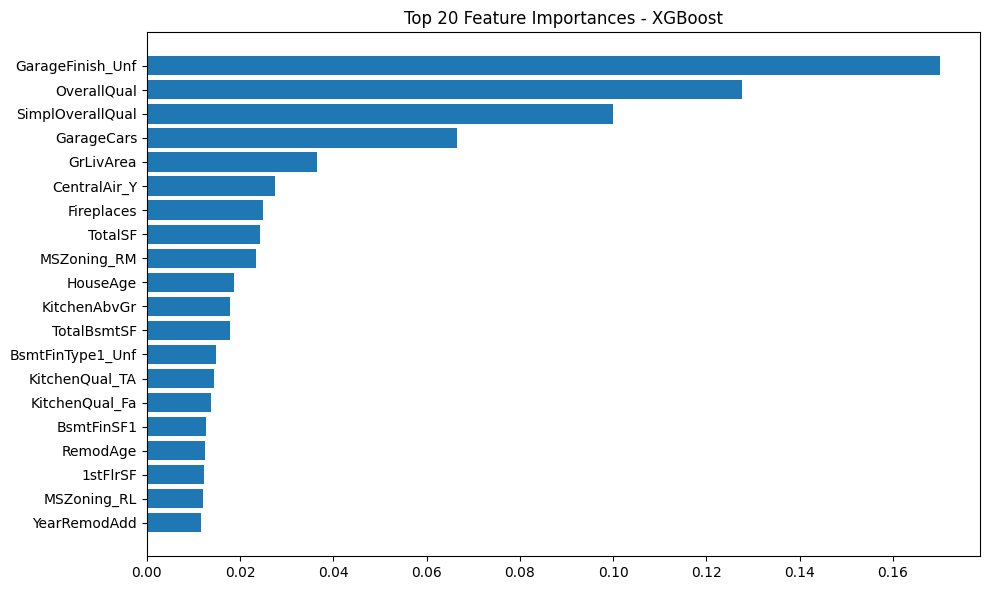

In [29]:
import matplotlib.pyplot as plt

xgb_importances = xgb_model.feature_importances_
indices = np.argsort(xgb_importances)[-20:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), xgb_importances[indices], align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.title("Top 20 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()


*  7.4. Train LightGBM Regressor with Early Stopping and RMSLE


# Checking how many features we used 

In [30]:
import pandas as pd

import pandas as pd

# Load train and test CSVs
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# Save SalePrice and ID columns for later
train_ID = train["Id"]
test_ID = test["Id"]
y = train["SalePrice"]

# Drop 'SalePrice' from train before combining
train.drop(["SalePrice"], axis=1, inplace=True)

# Combine datasets for consistent preprocessing
combined = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)

# ✅ Save column names BEFORE encoding
original_cols_before_encoding = combined.columns.tolist()

# Print count
print(f"📦 Original feature count before encoding: {len(original_cols_before_encoding)}")

# Step 1: Separate numeric and categorical
numeric_cols = combined.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = combined.select_dtypes(include='object').columns.tolist()

# Step 2: Count before encoding
original_feature_count = combined.shape[1]
print(f" Original features (with engineered): {original_feature_count}")

# Step 3: Apply one-hot encoding
combined_encoded = pd.get_dummies(combined)

# Step 4: Count after encoding
final_feature_count = combined_encoded.shape[1]
print(f" Final number of features after encoding: {final_feature_count}")

# Step 5: Calculate one-hot explosion
extra_columns = final_feature_count - original_feature_count
print(f" New columns created due to one-hot encoding: {extra_columns}")

# Step 6: Show how many new columns each categorical feature created
print("\n  One-hot columns per categorical feature:")
dummy_column_counts = {}

for col in categorical_cols:
    dummies = pd.get_dummies(combined[col], prefix=col)
    dummy_column_counts[col] = dummies.shape[1]

# Sort and display
for col, count in sorted(dummy_column_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count} columns")

# Optional: Total number of engineered features (based on your logic)
engineered_cols = ['TotalSF', 'HouseAge', 'RemodAge', 'GarageAge', 
                   'SimplOverallQual', 'SimplOverallCond']
print(f"\n🛠 Engineered features added: {len(engineered_cols)} → {engineered_cols}")


📦 Original feature count before encoding: 80
 Original features (with engineered): 80
 Final number of features after encoding: 288
 New columns created due to one-hot encoding: 208

  One-hot columns per categorical feature:
Neighborhood: 25 columns
Exterior2nd: 16 columns
Exterior1st: 15 columns
Condition1: 9 columns
SaleType: 9 columns
Condition2: 8 columns
HouseStyle: 8 columns
RoofMatl: 8 columns
Functional: 7 columns
RoofStyle: 6 columns
Foundation: 6 columns
BsmtFinType1: 6 columns
BsmtFinType2: 6 columns
Heating: 6 columns
GarageType: 6 columns
SaleCondition: 6 columns
MSZoning: 5 columns
LotConfig: 5 columns
BldgType: 5 columns
ExterCond: 5 columns
HeatingQC: 5 columns
Electrical: 5 columns
FireplaceQu: 5 columns
GarageQual: 5 columns
GarageCond: 5 columns
LotShape: 4 columns
LandContour: 4 columns
ExterQual: 4 columns
BsmtQual: 4 columns
BsmtCond: 4 columns
BsmtExposure: 4 columns
KitchenQual: 4 columns
Fence: 4 columns
MiscFeature: 4 columns
LandSlope: 3 columns
MasVnrType: 

# Testing and Final Steps

In [31]:
# Make predictions
final_preds = xgb_model.predict(test_set)

# Inverse log1p if target was log-transformed
final_preds = np.expm1(final_preds)

# Prepare submission
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": final_preds
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("✅ Submission file created!")


✅ Submission file created!


#  Model Evaluation (Train vs Validation RMSLE)

In [32]:
# Predict on training and validation
y_pred_train = xgb_model.predict(X_train)
y_pred_valid = xgb_model.predict(X_valid)

# Evaluate RMSLE
rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_pred_valid))

print(f" Train RMSLE: {rmsle_train:.4f}")
print(f" Valid RMSLE: {rmsle_valid:.4f}")


 Train RMSLE: 0.0057
 Valid RMSLE: 0.0103


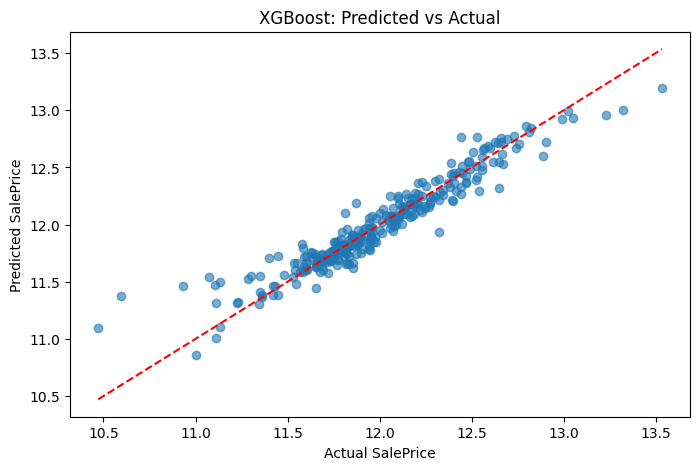

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_valid, y_pred_valid, alpha=0.6)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("XGBoost: Predicted vs Actual")
plt.show()
